In [1]:
import numpy as np

import torch
import pickle as pkl
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
use_cuda = False#torch.cuda.is_available()
# device = torch.device('cuda:6') if use_cuda else torch.device('cpu')

In [2]:
# with open('./data/diffusion_process_1d_N.pkl','rb') as f:
# with open('./data/diffusion_process_1d_field.pkl','rb') as f:
s_group_data=3
with open(f'./data/diffusion_process_1d_discrite_macro_s_group={s_group_data}.pkl','rb') as f:
# with open(f'./data/diffusion_process_1d_discrite.pkl','rb') as f:
    data = pkl.load(f)[:,:100,:]
data = torch.tensor(data,dtype=torch.float)
data.shape

torch.Size([50, 100, 100])

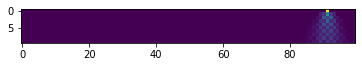

In [3]:
plt.imshow(data[0,:10,:])

In [4]:
t_group = 4
s_group = 2
data.shape
aa = data[:,:t_group*int((data.shape[1]-1)//t_group)+1,:s_group*int(data.shape[2]//s_group)]
print(aa.shape)
data_x = aa[:,:-1,:]
data_y = aa[:,1:,:]

torch.Size([50, 97, 100])


In [5]:
data_x.shape,data_y.shape

(torch.Size([50, 96, 100]), torch.Size([50, 96, 100]))

In [6]:
batch_size = 16
valid_ratio = 0.2
test_ratio = 0.2
L = data.shape[-1]
cut1 = int((valid_ratio+test_ratio)*data.shape[0])
cut2 =  int(test_ratio*data.shape[0])
print(cut1,cut2)
train_data_x = data_x[:cut1,:,:]
train_data_y = data_y[:cut1,:,:]
valid_data_x = data_x[cut1:cut1+cut2,:,:]
valid_data_y = data_y[cut1:cut1+cut2,:,:]
print(train_data_x.shape,valid_data_x.shape)
# print(dataset1)
dataset1 = torch.utils.data.dataset.TensorDataset(train_data_x, train_data_y)
dataset2 = torch.utils.data.dataset.TensorDataset(valid_data_x, valid_data_y)


train_loader = torch.utils.data.DataLoader(dataset=dataset1,
                                           batch_size=batch_size, 
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=dataset2,
                                           batch_size=batch_size, 
                                           shuffle=True)


20 10
torch.Size([20, 96, 100]) torch.Size([10, 96, 100])


In [7]:
import torch.nn.functional as F

class NormalizedConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,padding,padding_mode,stride=1):
        super(NormalizedConv1d, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, padding_mode=padding_mode, stride=stride,bias=False)
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        # 对权重进行归一化
        normed_weight = self.softmax(self.conv.weight)
#         print(self.conv.stride)
        return F.conv1d(x, normed_weight, self.conv.bias, stride=self.conv.stride,
                        padding=self.conv.padding, dilation=self.conv.dilation)

class Diffusion1D(nn.Module):
    def __init__(self,channel=1):
        super(Diffusion1D, self).__init__()
        kernel = 7
        self.normconv = NormalizedConv1d(1, channel, kernel, padding=1, padding_mode='same')
        self.relu = nn.ReLU()

    def forward(self, x):

        x = self.normconv(x.unsqueeze(1))

        x = torch.transpose(x,2,1).squeeze()
        return x
    


In [8]:
class TemporalSpatialConv(nn.Module):
    def __init__(self, tgroup = 4, sgroup=2):
        super(TemporalSpatialConv, self).__init__()
        self.tgroup = tgroup
        self.sgroup = sgroup
        # 空间卷积
        self.spatial_conv_weight = nn.Parameter(torch.randn(1, 1, sgroup))
        self.temporal_conv_weight = nn.Parameter(torch.randn(1, 1, tgroup))

        self.spatial_deconv_weight = nn.Parameter(torch.randn(1, 1, sgroup))
        self.temporal_deconv_weight = nn.Parameter(torch.randn(1, 1, tgroup))

        
        self.softmax = nn.Softmax(dim=-1)
    def forward(self, x):
        return x
    def Encoder(self, x):

        # 使用Softmax进行归一化
        spatial_conv_weight_normalized = F.softmax(self.spatial_conv_weight, dim=-1)
        temporal_conv_weight_normalized = F.softmax(self.temporal_conv_weight,dim=-1)*self.sgroup

        # 手动执行卷积操作
#         print(x.shape)
        b,t,l = x.shape
        x = x.reshape(-1,1,l)
        
        x = F.conv1d(x, spatial_conv_weight_normalized, stride=self.sgroup).reshape(b,t,l//self.sgroup)
#         print(x.shape)
        x = x.permute(0,2,1)
        x = x.reshape(-1,1,t)
        x = F.conv1d(x, temporal_conv_weight_normalized, stride=self.tgroup).reshape(b,l//self.sgroup,t//self.tgroup)
        x = x.permute(0,2,1)
#         x = F.relu(x)
        return x
    def Decoder(self, x):
        
        # 使用Softmax进行归一化
        spatial_conv_weight_normalized = F.softmax(self.spatial_conv_weight, dim=-1)
        temporal_conv_weight_normalized = F.softmax(self.temporal_conv_weight,dim=-1)

        # 手动执行卷积操作
        b,t,l = x.shape
        x = x.reshape(-1,1,l)
        
        x = F.conv_transpose1d(x, spatial_conv_weight_normalized, stride=self.sgroup).reshape(b,t,l*self.sgroup)
#         print(x.shape)
        x = x.permute(0,2,1)
        x = x.reshape(-1,1,t)
        x = F.conv_transpose1d(x, temporal_conv_weight_normalized, stride=self.tgroup).reshape(b,l*self.sgroup,t*self.tgroup)
        x = x.permute(0,2,1)

        return x
    

In [9]:
# dynamic = torch.load(f'./models/diffusion_dynamic_k=7.pth')
kernel_size=7
seed = 2050
dynamic = torch.load(f'./models/dynamic/diffusion_dynamic_s_group={s_group_data}_k={kernel_size}_{seed}.pth')
# dynamic = torch.load(f'./models/diffusion_dynamic.pth')
dynamic.eval()

Diffusion1D(
  (normconv): NormalizedConv1d(
    (conv): Conv1d(1, 1, kernel_size=(7,), stride=(1,), padding=same, bias=False)
    (softmax): Softmax(dim=-1)
  )
  (relu): ReLU()
)

In [10]:
NEAR_ZERO = 1e-10
sgroup = 2
tgroup = 2

  0%|                                                                                                                     | 0/10000 [00:00<?, ?it/s]

save
epoch: 0/10000: train loss:0.00030169716046657413,valid_loss:0.0003070555394515395


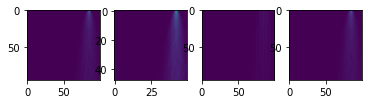

  0%|                                                                                                             | 9/10000 [00:00<12:24, 13.43it/s]

save
epoch: 10/10000: train loss:0.0002976261603180319,valid_loss:0.0003058009606320411


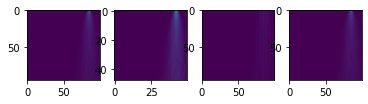

  0%|▏                                                                                                           | 19/10000 [00:01<10:53, 15.28it/s]

save
epoch: 20/10000: train loss:0.00029444225947372615,valid_loss:0.00030458607943728566


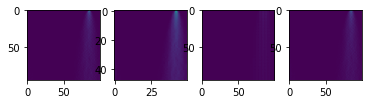

  0%|▎                                                                                                           | 29/10000 [00:02<10:25, 15.95it/s]

save
epoch: 30/10000: train loss:0.00029325867944862694,valid_loss:0.000303418084513396


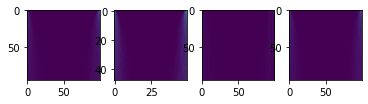

  0%|▍                                                                                                           | 39/10000 [00:03<10:38, 15.59it/s]

save
epoch: 40/10000: train loss:0.00029332994017750025,valid_loss:0.00030230352422222495


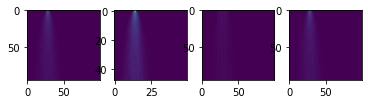

  0%|▌                                                                                                           | 49/10000 [00:03<11:40, 14.20it/s]

save
epoch: 50/10000: train loss:0.000290948009933345,valid_loss:0.00030124036129564047


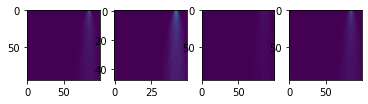

  1%|▋                                                                                                           | 59/10000 [00:04<10:58, 15.09it/s]

save
epoch: 60/10000: train loss:0.00028949913394171745,valid_loss:0.0003002311277668923


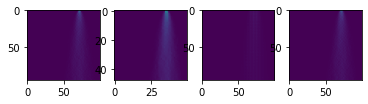

  1%|▋                                                                                                           | 69/10000 [00:05<10:58, 15.08it/s]

save
epoch: 70/10000: train loss:0.00028766534524038434,valid_loss:0.00029927611467428505


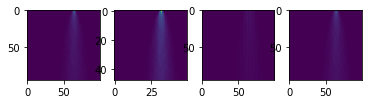

  1%|▊                                                                                                           | 79/10000 [00:06<10:35, 15.60it/s]

save
epoch: 80/10000: train loss:0.0002884459390770644,valid_loss:0.00029837479814887047


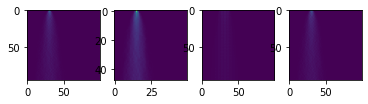

  1%|▉                                                                                                           | 89/10000 [00:06<10:45, 15.36it/s]

save
epoch: 90/10000: train loss:0.0002887016744352877,valid_loss:0.0002975266834255308


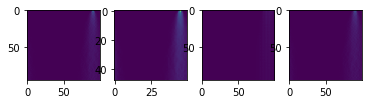

  1%|█                                                                                                           | 99/10000 [00:07<10:47, 15.30it/s]

save
epoch: 100/10000: train loss:0.0002897069352911785,valid_loss:0.000296733807772398


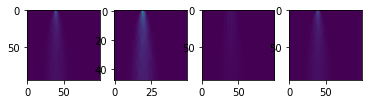

  1%|█▏                                                                                                         | 109/10000 [00:08<10:33, 15.61it/s]

save
epoch: 110/10000: train loss:0.0002842615358531475,valid_loss:0.0002959940757136792


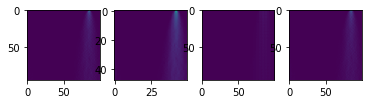

  1%|█▎                                                                                                         | 119/10000 [00:09<10:21, 15.89it/s]

save
epoch: 120/10000: train loss:0.0002898484672186896,valid_loss:0.0002953051298391074


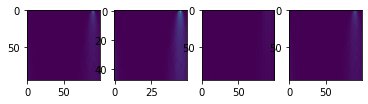

  1%|█▍                                                                                                         | 129/10000 [00:09<10:41, 15.40it/s]

save
epoch: 130/10000: train loss:0.0002882392145693302,valid_loss:0.00029466699925251305


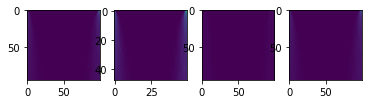

  1%|█▍                                                                                                         | 139/10000 [00:10<10:39, 15.41it/s]

save
epoch: 140/10000: train loss:0.0002817476779455319,valid_loss:0.0002940773847512901


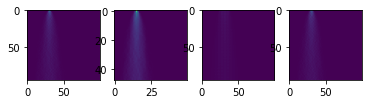

  1%|█▌                                                                                                         | 149/10000 [00:11<11:31, 14.24it/s]

save
epoch: 150/10000: train loss:0.0002880207321140915,valid_loss:0.00029353518038988113


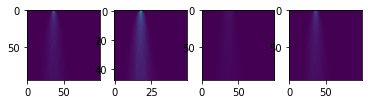

  2%|█▋                                                                                                         | 159/10000 [00:12<10:34, 15.50it/s]

save
epoch: 160/10000: train loss:0.00028816315170843154,valid_loss:0.0002930379705503583


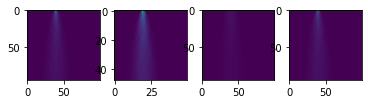

  2%|█▊                                                                                                         | 169/10000 [00:13<10:57, 14.96it/s]

save
epoch: 170/10000: train loss:0.0002840994857251644,valid_loss:0.0002925818844232708


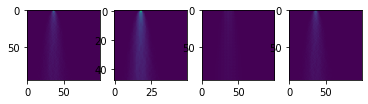

  2%|█▉                                                                                                         | 179/10000 [00:13<11:21, 14.41it/s]

save
epoch: 180/10000: train loss:0.0002863170375349,valid_loss:0.0002921672712545842


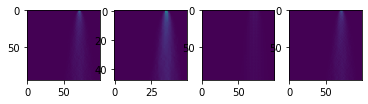

  2%|██                                                                                                         | 189/10000 [00:14<10:56, 14.94it/s]

save
epoch: 190/10000: train loss:0.00028510295669548213,valid_loss:0.00029179101693443954


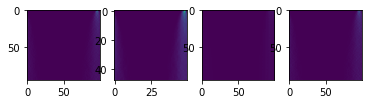

  2%|██▏                                                                                                        | 199/10000 [00:15<10:48, 15.12it/s]

save
epoch: 200/10000: train loss:0.00028209453739691526,valid_loss:0.00029145096777938306


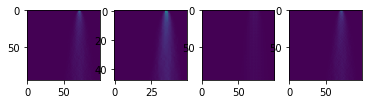

  2%|██▏                                                                                                        | 209/10000 [00:16<11:28, 14.22it/s]

save
epoch: 210/10000: train loss:0.00028387353813741356,valid_loss:0.00029114470817148685


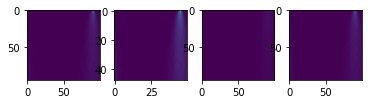

  2%|██▎                                                                                                        | 219/10000 [00:17<10:46, 15.14it/s]

save
epoch: 220/10000: train loss:0.0002804278919938952,valid_loss:0.00029086999711580575


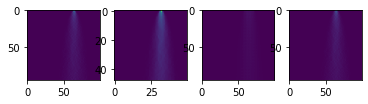

  2%|██▍                                                                                                        | 229/10000 [00:17<10:37, 15.34it/s]

save
epoch: 230/10000: train loss:0.00028002769977319986,valid_loss:0.0002906237496063113


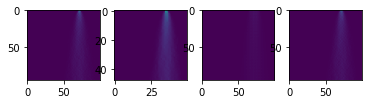

  2%|██▌                                                                                                        | 239/10000 [00:18<10:35, 15.36it/s]

save
epoch: 240/10000: train loss:0.00027881161076948047,valid_loss:0.0002904054999817163


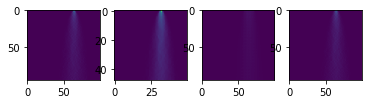

  2%|██▋                                                                                                        | 249/10000 [00:19<11:05, 14.65it/s]

save
epoch: 250/10000: train loss:0.0002869841118808836,valid_loss:0.0002902131818700582


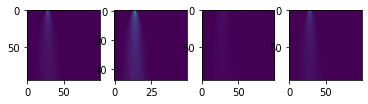

  3%|██▊                                                                                                        | 259/10000 [00:20<10:43, 15.14it/s]

save
epoch: 260/10000: train loss:0.00028321638819761574,valid_loss:0.0002900421095546335


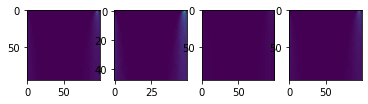

  3%|██▉                                                                                                        | 269/10000 [00:20<11:01, 14.71it/s]

save
epoch: 270/10000: train loss:0.00027752712776418775,valid_loss:0.0002898912935052067


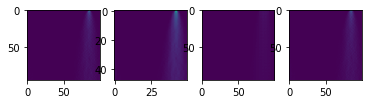

  3%|██▉                                                                                                        | 279/10000 [00:21<10:42, 15.14it/s]

save
epoch: 280/10000: train loss:0.00028166429547127336,valid_loss:0.00028975895838811994


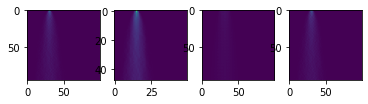

  3%|███                                                                                                        | 289/10000 [00:22<10:38, 15.21it/s]

save
epoch: 290/10000: train loss:0.0002794002793962136,valid_loss:0.00028964370721951127


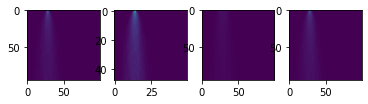

  3%|███▏                                                                                                       | 299/10000 [00:23<10:34, 15.30it/s]

save
epoch: 300/10000: train loss:0.0002788577839965001,valid_loss:0.0002895429788623005


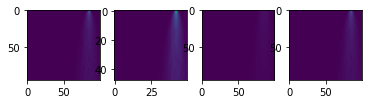

  3%|███▎                                                                                                       | 309/10000 [00:23<10:45, 15.02it/s]

save
epoch: 310/10000: train loss:0.00027809735911432654,valid_loss:0.00028945537633262575


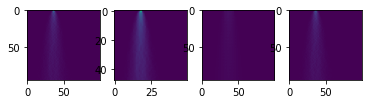

  3%|███▍                                                                                                       | 319/10000 [00:24<10:52, 14.84it/s]

save
epoch: 320/10000: train loss:0.0002784087118925527,valid_loss:0.00028938002651557326


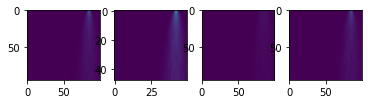

  3%|███▌                                                                                                       | 329/10000 [00:25<10:42, 15.05it/s]

save
epoch: 330/10000: train loss:0.0002774088643491268,valid_loss:0.0002893147466238588


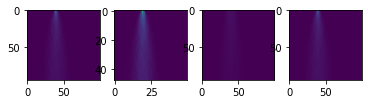

  3%|███▋                                                                                                       | 339/10000 [00:26<10:33, 15.25it/s]

save
epoch: 340/10000: train loss:0.0002799557987600565,valid_loss:0.00028925848891958594


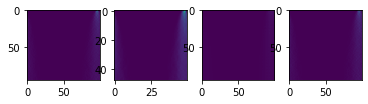

  3%|███▋                                                                                                       | 349/10000 [00:26<10:17, 15.62it/s]

save
epoch: 350/10000: train loss:0.0002785073156701401,valid_loss:0.00028921052580699325


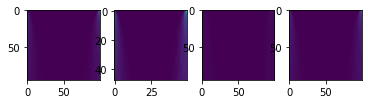

  4%|███▊                                                                                                       | 359/10000 [00:27<10:05, 15.92it/s]

save
epoch: 360/10000: train loss:0.00027671361749526113,valid_loss:0.0002891694020945579


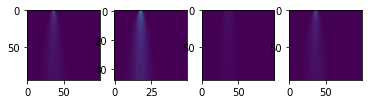

  4%|███▉                                                                                                       | 369/10000 [00:28<10:16, 15.61it/s]

save
epoch: 370/10000: train loss:0.0002760792413027957,valid_loss:0.000289134361082688


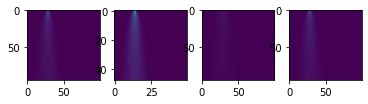

  4%|████                                                                                                       | 379/10000 [00:29<10:45, 14.90it/s]

save
epoch: 380/10000: train loss:0.0002798959903884679,valid_loss:0.0002891040639951825


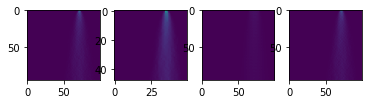

  4%|████▏                                                                                                      | 389/10000 [00:30<10:40, 15.01it/s]

save
epoch: 390/10000: train loss:0.0002772120642475784,valid_loss:0.000289078161586076


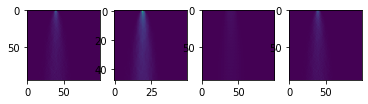

  4%|████▎                                                                                                      | 399/10000 [00:30<10:23, 15.39it/s]

save
epoch: 400/10000: train loss:0.0002821909583872184,valid_loss:0.0002890560426749289


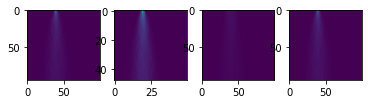

  4%|████▍                                                                                                      | 409/10000 [00:31<10:37, 15.04it/s]

save
epoch: 410/10000: train loss:0.00028082169592380524,valid_loss:0.00028903718339279294


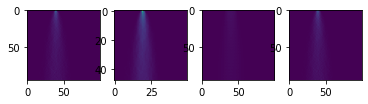

  4%|████▍                                                                                                      | 419/10000 [00:32<10:39, 14.98it/s]

save
epoch: 420/10000: train loss:0.000277380648185499,valid_loss:0.0002890212053898722


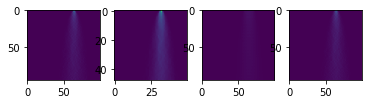

  4%|████▌                                                                                                      | 429/10000 [00:33<10:30, 15.18it/s]

save
epoch: 430/10000: train loss:0.0002758828632067889,valid_loss:0.0002890072937589139


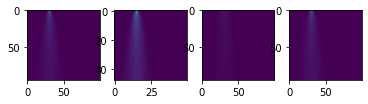

  4%|████▋                                                                                                      | 439/10000 [00:33<10:16, 15.50it/s]

save
epoch: 440/10000: train loss:0.0002800425427267328,valid_loss:0.00028899512835778296


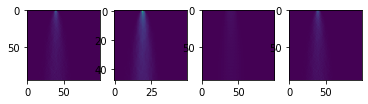

  4%|████▊                                                                                                      | 449/10000 [00:34<10:25, 15.27it/s]

save
epoch: 450/10000: train loss:0.0002768866834230721,valid_loss:0.00028898456366732717


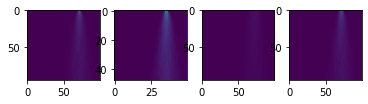

  5%|████▉                                                                                                      | 459/10000 [00:35<10:34, 15.03it/s]

save
epoch: 460/10000: train loss:0.0002763657394098118,valid_loss:0.000288974930299446


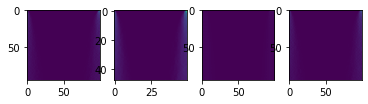

  5%|█████                                                                                                      | 469/10000 [00:36<10:26, 15.21it/s]

save
epoch: 470/10000: train loss:0.00027724457322619855,valid_loss:0.00028896628646180034


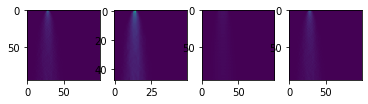

  5%|█████▏                                                                                                     | 479/10000 [00:36<10:20, 15.34it/s]

save
epoch: 480/10000: train loss:0.0002796543703880161,valid_loss:0.00028895860305055976


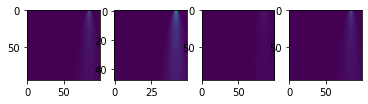

  5%|█████▏                                                                                                     | 489/10000 [00:37<09:55, 15.97it/s]

save
epoch: 490/10000: train loss:0.00027782384131569415,valid_loss:0.00028895126888528466


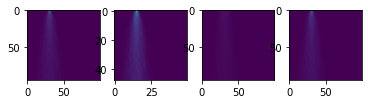

  5%|█████▎                                                                                                     | 499/10000 [00:38<09:43, 16.29it/s]

save
epoch: 500/10000: train loss:0.000276353326626122,valid_loss:0.00028894442948512733


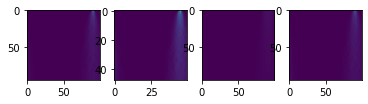

  5%|█████▍                                                                                                     | 509/10000 [00:38<09:44, 16.23it/s]

save
epoch: 510/10000: train loss:0.0002767090772977099,valid_loss:0.0002889379393309355


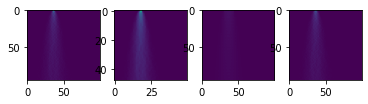

  5%|█████▌                                                                                                     | 519/10000 [00:39<09:43, 16.26it/s]

save
epoch: 520/10000: train loss:0.00027574447449296713,valid_loss:0.0002889316529035568


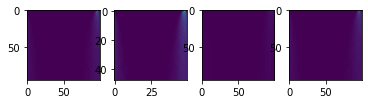

  5%|█████▋                                                                                                     | 529/10000 [00:40<09:56, 15.88it/s]

save
epoch: 530/10000: train loss:0.00027635118749458343,valid_loss:0.0002889255410991609


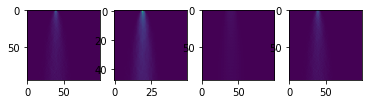

  5%|█████▊                                                                                                     | 539/10000 [00:41<09:46, 16.14it/s]

save
epoch: 540/10000: train loss:0.0002773447340587154,valid_loss:0.00028891945839859545


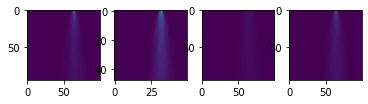

  5%|█████▊                                                                                                     | 549/10000 [00:41<09:41, 16.26it/s]

save
epoch: 550/10000: train loss:0.0002786462282529101,valid_loss:0.00028891346300952137


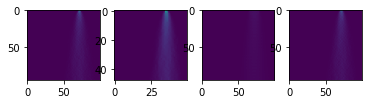

  6%|█████▉                                                                                                     | 559/10000 [00:42<09:40, 16.27it/s]

save
epoch: 560/10000: train loss:0.00027607603988144547,valid_loss:0.00028890735120512545


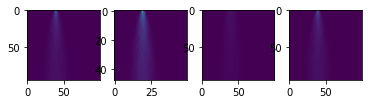

  6%|██████                                                                                                     | 569/10000 [00:43<10:14, 15.36it/s]

save
epoch: 570/10000: train loss:0.0002766672259895131,valid_loss:0.00028890129760839045


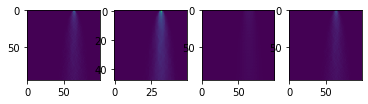

  6%|██████▏                                                                                                    | 579/10000 [00:43<09:44, 16.12it/s]

save
epoch: 580/10000: train loss:0.00027551640232559294,valid_loss:0.00028889530221931636


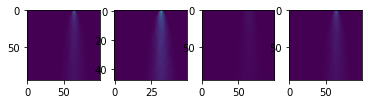

  6%|██████▎                                                                                                    | 589/10000 [00:44<09:39, 16.24it/s]

save
epoch: 590/10000: train loss:0.00028020128956995904,valid_loss:0.0002888891031034291


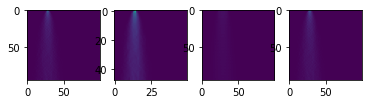

  6%|██████▍                                                                                                    | 599/10000 [00:45<09:53, 15.84it/s]

save
epoch: 600/10000: train loss:0.0002764529490377754,valid_loss:0.00028888293309137225


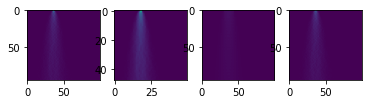

  6%|██████▌                                                                                                    | 609/10000 [00:46<09:39, 16.21it/s]

save
epoch: 610/10000: train loss:0.00028040776669513434,valid_loss:0.0002888766466639936


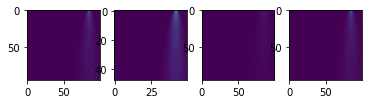

  6%|██████▌                                                                                                    | 619/10000 [00:46<09:37, 16.24it/s]

save
epoch: 620/10000: train loss:0.00028284457221161574,valid_loss:0.00028887027292512357


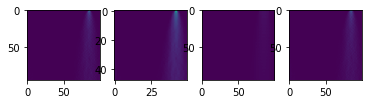

  6%|██████▋                                                                                                    | 629/10000 [00:47<09:37, 16.24it/s]

save
epoch: 630/10000: train loss:0.00027823341952171177,valid_loss:0.0002888638118747622


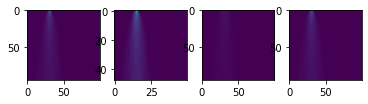

  6%|██████▊                                                                                                    | 639/10000 [00:48<09:39, 16.15it/s]

save
epoch: 640/10000: train loss:0.0002765011304290965,valid_loss:0.0002888574090320617


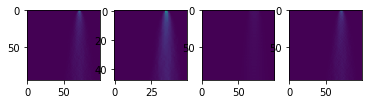

  6%|██████▉                                                                                                    | 649/10000 [00:49<09:36, 16.21it/s]

save
epoch: 650/10000: train loss:0.00027961198065895587,valid_loss:0.0002888507442548871


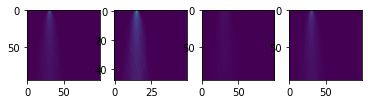

  7%|███████                                                                                                    | 659/10000 [00:49<09:35, 16.22it/s]

save
epoch: 660/10000: train loss:0.000279931424302049,valid_loss:0.00028884399216622114


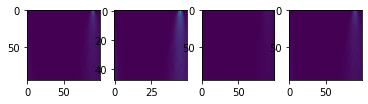

  7%|███████▏                                                                                                   | 669/10000 [00:50<09:39, 16.10it/s]

save
epoch: 670/10000: train loss:0.00027770591259468347,valid_loss:0.00028883726918138564


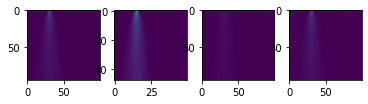

  7%|███████▎                                                                                                   | 679/10000 [00:51<09:31, 16.31it/s]

save
epoch: 680/10000: train loss:0.000277908708085306,valid_loss:0.00028883040067739785


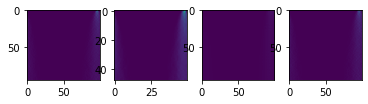

  7%|███████▎                                                                                                   | 689/10000 [00:51<09:34, 16.22it/s]

save
epoch: 690/10000: train loss:0.0002812390011968091,valid_loss:0.0002888235612772405


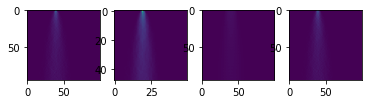

  7%|███████▍                                                                                                   | 699/10000 [00:52<09:30, 16.30it/s]

save
epoch: 700/10000: train loss:0.00027807227161247283,valid_loss:0.00028881666366942227


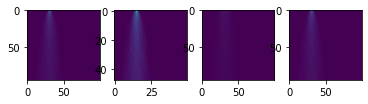

  7%|███████▌                                                                                                   | 709/10000 [00:53<09:32, 16.24it/s]

save
epoch: 710/10000: train loss:0.00027583852352108806,valid_loss:0.000288809766061604


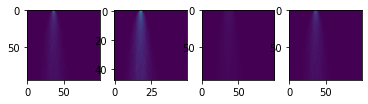

  7%|███████▋                                                                                                   | 719/10000 [00:54<09:31, 16.23it/s]

save
epoch: 720/10000: train loss:0.0002791412698570639,valid_loss:0.0002888028684537858


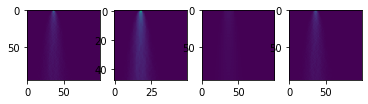

  7%|███████▊                                                                                                   | 729/10000 [00:54<09:31, 16.23it/s]

save
epoch: 730/10000: train loss:0.0002771442668745294,valid_loss:0.0002887958544306457


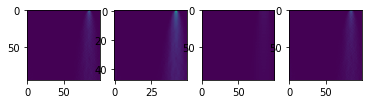

  7%|███████▉                                                                                                   | 739/10000 [00:55<09:42, 15.89it/s]

save
epoch: 740/10000: train loss:0.0002766541874734685,valid_loss:0.0002887889859266579


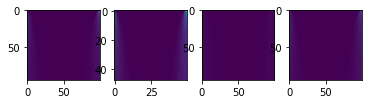

  7%|████████                                                                                                   | 749/10000 [00:56<09:31, 16.19it/s]

save
epoch: 750/10000: train loss:0.0002786397380987182,valid_loss:0.0002887822047341615


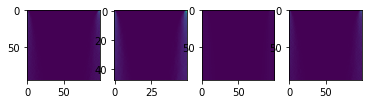

  8%|████████                                                                                                   | 759/10000 [00:56<09:28, 16.27it/s]

save
epoch: 760/10000: train loss:0.0002760063507594168,valid_loss:0.0002887753944378346


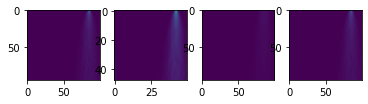

  8%|████████▏                                                                                                  | 769/10000 [00:57<09:28, 16.25it/s]

save
epoch: 770/10000: train loss:0.0002773127780528739,valid_loss:0.00028876843862235546


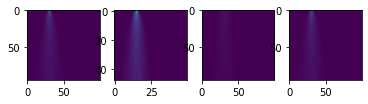

  8%|████████▎                                                                                                  | 779/10000 [00:58<09:29, 16.20it/s]

save
epoch: 780/10000: train loss:0.0002814883628161624,valid_loss:0.00028876165742985904


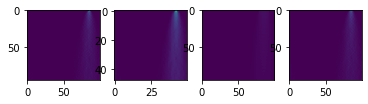

  8%|████████▍                                                                                                  | 789/10000 [00:59<09:27, 16.22it/s]

save
epoch: 790/10000: train loss:0.0002766142424661666,valid_loss:0.0002887549053411931


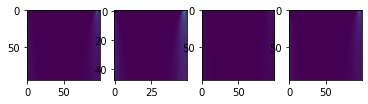

  8%|████████▌                                                                                                  | 799/10000 [00:59<09:27, 16.20it/s]

save
epoch: 800/10000: train loss:0.00028034606657456607,valid_loss:0.0002887481823563576


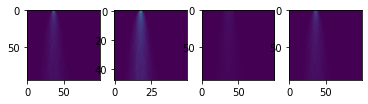

  8%|████████▋                                                                                                  | 809/10000 [01:00<09:33, 16.01it/s]

save
epoch: 810/10000: train loss:0.0002762411895673722,valid_loss:0.0002887414302676916


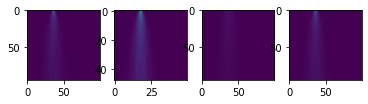

  8%|████████▊                                                                                                  | 819/10000 [01:01<09:41, 15.79it/s]

save
epoch: 820/10000: train loss:0.0002798347850330174,valid_loss:0.0002887347945943475


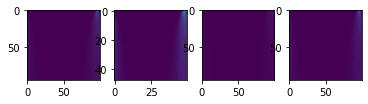

  8%|████████▊                                                                                                  | 829/10000 [01:01<09:26, 16.20it/s]

save
epoch: 830/10000: train loss:0.0002767559344647452,valid_loss:0.0002887282462324947


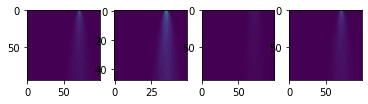

  8%|████████▉                                                                                                  | 839/10000 [01:02<09:24, 16.22it/s]

save
epoch: 840/10000: train loss:0.0002781718212645501,valid_loss:0.0002887217269744724


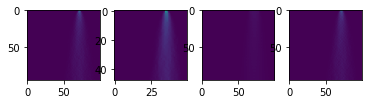

  8%|█████████                                                                                                  | 849/10000 [01:03<09:36, 15.88it/s]

save
epoch: 850/10000: train loss:0.00027702680381480604,valid_loss:0.0002887152077164501


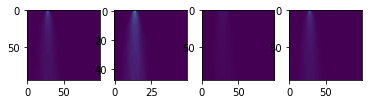

  9%|█████████▏                                                                                                 | 859/10000 [01:04<09:27, 16.12it/s]

save
epoch: 860/10000: train loss:0.00028069582185707986,valid_loss:0.00028870897949673235


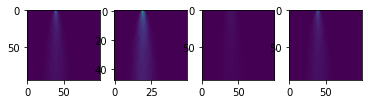

  9%|█████████▎                                                                                                 | 869/10000 [01:04<09:29, 16.04it/s]

save
epoch: 870/10000: train loss:0.00028035575815010816,valid_loss:0.0002887026930693537


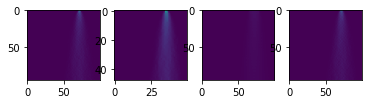

  9%|█████████▍                                                                                                 | 879/10000 [01:05<09:54, 15.35it/s]

save
epoch: 880/10000: train loss:0.0002799187059281394,valid_loss:0.00028869661036878824


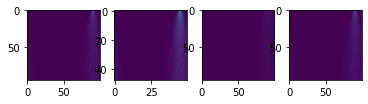

  9%|█████████▌                                                                                                 | 889/10000 [01:06<09:27, 16.07it/s]

save
epoch: 890/10000: train loss:0.00027962263266090304,valid_loss:0.00028869055677205324


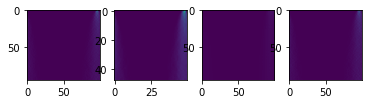

  9%|█████████▌                                                                                                 | 899/10000 [01:06<09:20, 16.23it/s]

save
epoch: 900/10000: train loss:0.000281447617453523,valid_loss:0.0002886845904868096


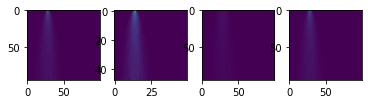

  9%|█████████▋                                                                                                 | 909/10000 [01:07<09:19, 16.24it/s]

save
epoch: 910/10000: train loss:0.00028077131719328463,valid_loss:0.00028867891523987055


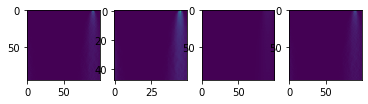

  9%|█████████▊                                                                                                 | 919/10000 [01:08<09:17, 16.28it/s]

save
epoch: 920/10000: train loss:0.00027722344384528697,valid_loss:0.00028867312357760966


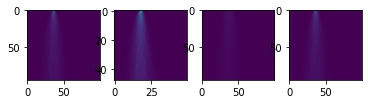

  9%|█████████▉                                                                                                 | 929/10000 [01:09<09:16, 16.29it/s]

save
epoch: 930/10000: train loss:0.0002765545650618151,valid_loss:0.0002886675065383315


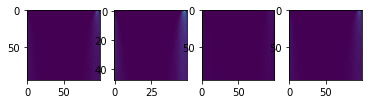

  9%|██████████                                                                                                 | 939/10000 [01:09<09:15, 16.30it/s]

save
epoch: 940/10000: train loss:0.0002803041716106236,valid_loss:0.00028866209322586656


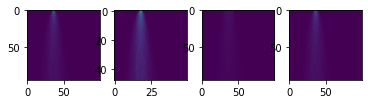

  9%|██████████▏                                                                                                | 949/10000 [01:10<09:29, 15.90it/s]

save
epoch: 950/10000: train loss:0.00027624961512628943,valid_loss:0.0002886567381210625


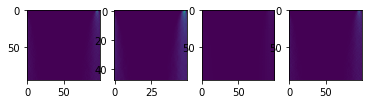

 10%|██████████▎                                                                                                | 959/10000 [01:11<09:21, 16.10it/s]

save
epoch: 960/10000: train loss:0.0002773265296127647,valid_loss:0.0002886514994315803


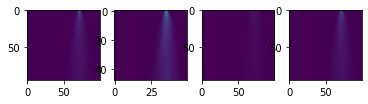

 10%|██████████▎                                                                                                | 969/10000 [01:12<09:29, 15.85it/s]

save
epoch: 970/10000: train loss:0.00027800646785181016,valid_loss:0.0002886462607420981


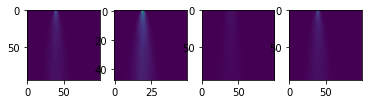

 10%|██████████▍                                                                                                | 979/10000 [01:12<09:17, 16.18it/s]

save
epoch: 980/10000: train loss:0.00027945746842306107,valid_loss:0.0002886413421947509


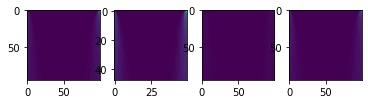

 10%|██████████▌                                                                                                | 989/10000 [01:13<09:16, 16.20it/s]

save
epoch: 990/10000: train loss:0.00027744314866140485,valid_loss:0.0002886365109588951


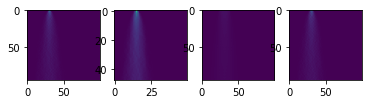

 10%|██████████▋                                                                                                | 999/10000 [01:14<09:13, 16.26it/s]

save
epoch: 1000/10000: train loss:0.0002837013453245163,valid_loss:0.00028863182524219155


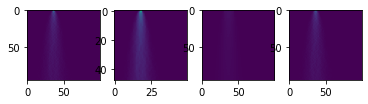

 10%|██████████▋                                                                                               | 1009/10000 [01:14<09:12, 16.28it/s]

save
epoch: 1010/10000: train loss:0.0002790279686450958,valid_loss:0.00028862719773314893


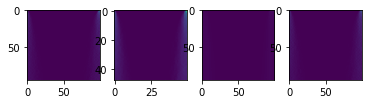

 10%|██████████▊                                                                                               | 1019/10000 [01:15<09:21, 15.99it/s]

save
epoch: 1020/10000: train loss:0.0002814192557707429,valid_loss:0.0002886227739509195


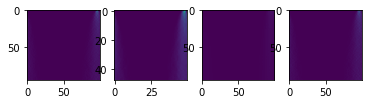

 10%|██████████▉                                                                                               | 1029/10000 [01:16<09:12, 16.23it/s]

save
epoch: 1030/10000: train loss:0.00027863611467182636,valid_loss:0.0002886185247916728


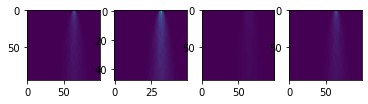

 10%|███████████                                                                                               | 1039/10000 [01:17<09:10, 16.28it/s]

save
epoch: 1040/10000: train loss:0.0002782528899842873,valid_loss:0.0002886143629439175


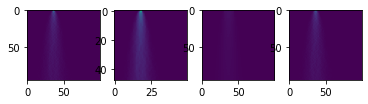

 10%|███████████                                                                                               | 1049/10000 [01:17<09:10, 16.26it/s]

save
epoch: 1050/10000: train loss:0.00028100131021346897,valid_loss:0.00028861028840765357


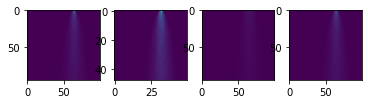

 11%|███████████▏                                                                                              | 1059/10000 [01:18<09:09, 16.27it/s]

save
epoch: 1060/10000: train loss:0.0002790731086861342,valid_loss:0.0002886065049096942


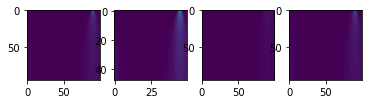

 11%|███████████▎                                                                                              | 1069/10000 [01:19<09:09, 16.25it/s]

save
epoch: 1070/10000: train loss:0.00027730064175557345,valid_loss:0.00028860277961939573


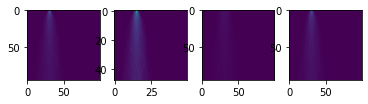

 11%|███████████▍                                                                                              | 1079/10000 [01:19<09:10, 16.21it/s]

save
epoch: 1080/10000: train loss:0.0002769791317405179,valid_loss:0.00028859919984824955


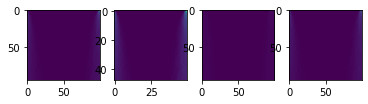

 11%|███████████▌                                                                                              | 1089/10000 [01:20<09:15, 16.05it/s]

save
epoch: 1090/10000: train loss:0.0002767141704680398,valid_loss:0.0002885958238039166


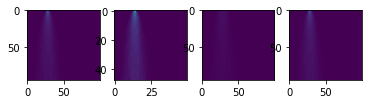

 11%|███████████▋                                                                                              | 1099/10000 [01:21<09:08, 16.22it/s]

save
epoch: 1100/10000: train loss:0.0002761958457995206,valid_loss:0.00028859253507107496


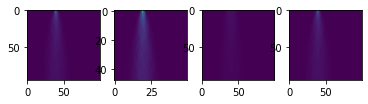

 11%|███████████▊                                                                                              | 1109/10000 [01:22<09:07, 16.25it/s]

save
epoch: 1110/10000: train loss:0.00027718635101336986,valid_loss:0.0002885893627535552


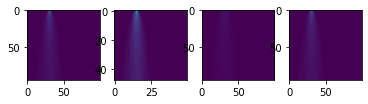

 11%|███████████▊                                                                                              | 1119/10000 [01:22<09:05, 16.29it/s]

save
epoch: 1120/10000: train loss:0.00027946889167651534,valid_loss:0.0002885863359551877


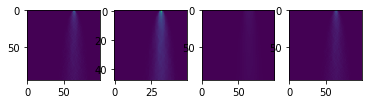

 11%|███████████▉                                                                                              | 1129/10000 [01:23<09:05, 16.26it/s]

save
epoch: 1130/10000: train loss:0.00027628680982161313,valid_loss:0.0002885835710912943


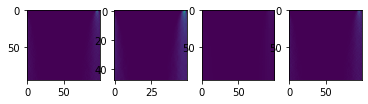

 11%|████████████                                                                                              | 1139/10000 [01:24<11:10, 13.22it/s]

save
epoch: 1140/10000: train loss:0.0002755648165475577,valid_loss:0.0002885808062274009


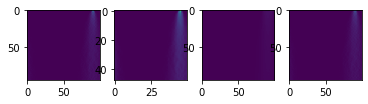

 11%|████████████▏                                                                                             | 1149/10000 [01:25<09:26, 15.62it/s]

save
epoch: 1150/10000: train loss:0.00027698274061549455,valid_loss:0.0002885782450903207


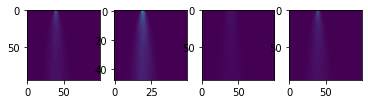

 12%|████████████▎                                                                                             | 1159/10000 [01:25<09:31, 15.46it/s]

save
epoch: 1160/10000: train loss:0.00027939019491896033,valid_loss:0.00028857559664174914


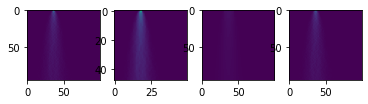

 12%|████████████▍                                                                                             | 1169/10000 [01:26<09:07, 16.12it/s]

save
epoch: 1170/10000: train loss:0.0002769181883195415,valid_loss:0.00028857323923148215


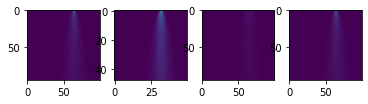

 12%|████████████▍                                                                                             | 1179/10000 [01:27<09:03, 16.24it/s]

save
epoch: 1180/10000: train loss:0.00027666823007166386,valid_loss:0.000288570998236537


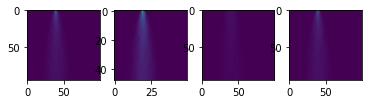

 12%|████████████▌                                                                                             | 1189/10000 [01:27<09:00, 16.29it/s]

save
epoch: 1190/10000: train loss:0.0002763705124380067,valid_loss:0.000288568960968405


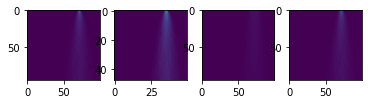

 12%|████████████▋                                                                                             | 1199/10000 [01:28<08:59, 16.32it/s]

save
epoch: 1200/10000: train loss:0.0002765747922239825,valid_loss:0.0002885670692194253


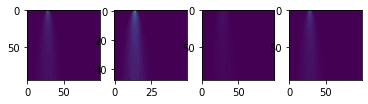

 12%|████████████▊                                                                                             | 1209/10000 [01:29<09:02, 16.21it/s]

save
epoch: 1210/10000: train loss:0.0002759495109785348,valid_loss:0.0002885652065742761


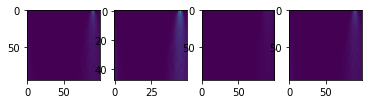

 12%|████████████▉                                                                                             | 1219/10000 [01:30<09:01, 16.23it/s]

save
epoch: 1220/10000: train loss:0.00028196530183777213,valid_loss:0.00028856340213678777


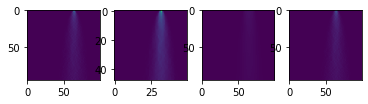

 12%|█████████████                                                                                             | 1229/10000 [01:30<09:08, 15.99it/s]

save
epoch: 1230/10000: train loss:0.00027945237525273114,valid_loss:0.00028856180142611265


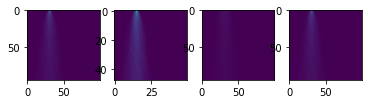

 12%|█████████████▏                                                                                            | 1239/10000 [01:31<08:59, 16.23it/s]

save
epoch: 1240/10000: train loss:0.0002803997485898435,valid_loss:0.00028856025892309844


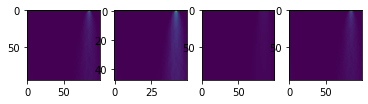

 12%|█████████████▏                                                                                            | 1249/10000 [01:32<09:00, 16.18it/s]

save
epoch: 1250/10000: train loss:0.00028153152379672974,valid_loss:0.0002885588619392365


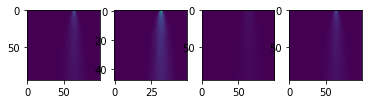

 13%|█████████████▎                                                                                            | 1259/10000 [01:32<09:05, 16.04it/s]

save
epoch: 1260/10000: train loss:0.0002762005169643089,valid_loss:0.0002885575231630355


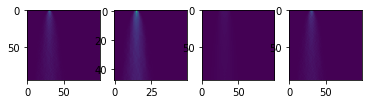

 13%|█████████████▍                                                                                            | 1269/10000 [01:33<08:59, 16.18it/s]

save
epoch: 1270/10000: train loss:0.00027617282466962934,valid_loss:0.00028855635900981724


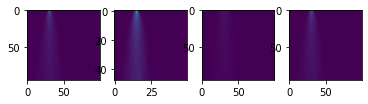

 13%|█████████████▌                                                                                            | 1279/10000 [01:34<08:56, 16.25it/s]

save
epoch: 1280/10000: train loss:0.00027669341943692416,valid_loss:0.000288555194856599


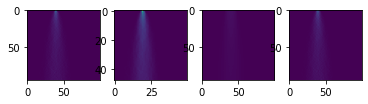

 13%|█████████████▋                                                                                            | 1289/10000 [01:35<08:58, 16.17it/s]

save
epoch: 1290/10000: train loss:0.00027768686413764954,valid_loss:0.00028855420532636344


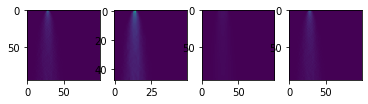

 13%|█████████████▊                                                                                            | 1299/10000 [01:35<09:45, 14.87it/s]

save
epoch: 1300/10000: train loss:0.0002824664261424914,valid_loss:0.0002885533031076193


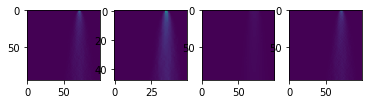

 13%|█████████████▉                                                                                            | 1309/10000 [01:36<09:03, 15.98it/s]

save
epoch: 1310/10000: train loss:0.00027569220401346684,valid_loss:0.0002885524008888751


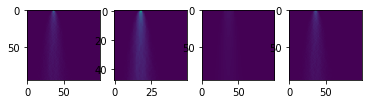

 13%|█████████████▉                                                                                            | 1319/10000 [01:37<08:53, 16.27it/s]

save
epoch: 1320/10000: train loss:0.00027896271785721183,valid_loss:0.0002885516150854528


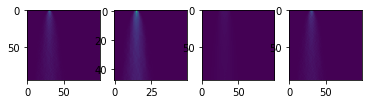

 13%|██████████████                                                                                            | 1329/10000 [01:38<08:50, 16.34it/s]

save
epoch: 1330/10000: train loss:0.00027873732324223965,valid_loss:0.0002885509456973523


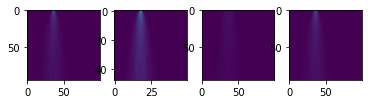

 13%|██████████████▏                                                                                           | 1339/10000 [01:38<08:51, 16.30it/s]

save
epoch: 1340/10000: train loss:0.0002807141136145219,valid_loss:0.00028855036362074316


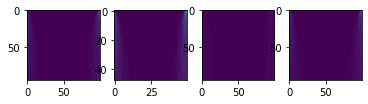

 13%|██████████████▎                                                                                           | 1349/10000 [01:39<08:52, 16.23it/s]

save
epoch: 1350/10000: train loss:0.0002770517603494227,valid_loss:0.00028854975244030356


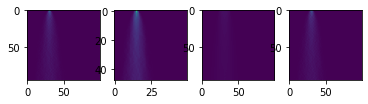

 14%|██████████████▍                                                                                           | 1359/10000 [01:40<08:50, 16.28it/s]

save
epoch: 1360/10000: train loss:0.00028074464353267103,valid_loss:0.00028854928677901626


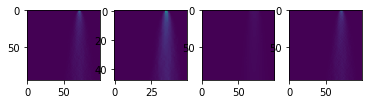

 14%|██████████████▌                                                                                           | 1369/10000 [01:40<09:00, 15.97it/s]

save
epoch: 1370/10000: train loss:0.00028204206319060177,valid_loss:0.0002885489084292203


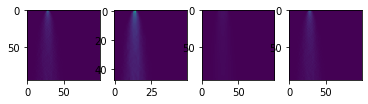

 14%|██████████████▌                                                                                           | 1379/10000 [01:41<08:52, 16.20it/s]

save
epoch: 1380/10000: train loss:0.0002769292041193694,valid_loss:0.00028854855918325484


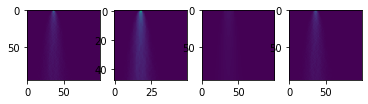

 14%|██████████████▋                                                                                           | 1389/10000 [01:42<08:56, 16.06it/s]

save
epoch: 1390/10000: train loss:0.0002768196281976998,valid_loss:0.00028854826814495027


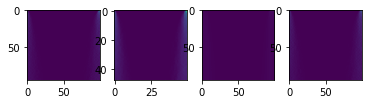

 14%|██████████████▊                                                                                           | 1399/10000 [01:43<08:50, 16.22it/s]

save
epoch: 1400/10000: train loss:0.0002809318102663383,valid_loss:0.0002885479771066457


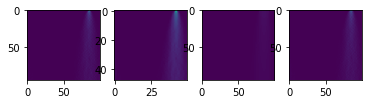

 14%|██████████████▉                                                                                           | 1409/10000 [01:43<08:49, 16.22it/s]

save
epoch: 1410/10000: train loss:0.0002753171429503709,valid_loss:0.00028854774427600205


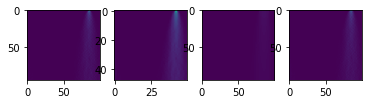

 14%|███████████████                                                                                           | 1419/10000 [01:44<08:46, 16.29it/s]

save
epoch: 1420/10000: train loss:0.00028102140640839934,valid_loss:0.00028854759875684977


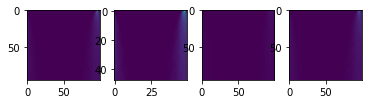

 14%|███████████████▏                                                                                          | 1429/10000 [01:45<08:49, 16.18it/s]

save
epoch: 1430/10000: train loss:0.00027863508148584515,valid_loss:0.00028854748234152794


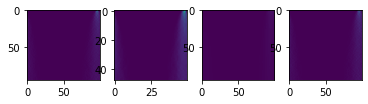

 14%|███████████████▎                                                                                          | 1439/10000 [01:46<08:54, 16.02it/s]

save
epoch: 1440/10000: train loss:0.00027733588649425656,valid_loss:0.00028854739503003657


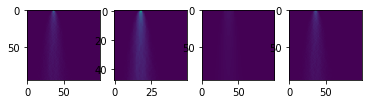

 14%|███████████████▎                                                                                          | 1449/10000 [01:46<08:45, 16.28it/s]

epoch: 1450/10000: train loss:0.00027659603802021593,valid_loss:0.000288547424133867


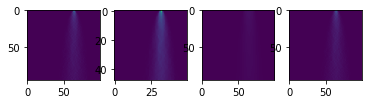

 15%|███████████████▍                                                                                          | 1459/10000 [01:47<08:44, 16.28it/s]

epoch: 1460/10000: train loss:0.00027688511181622744,valid_loss:0.000288547424133867


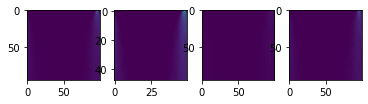

 15%|███████████████▌                                                                                          | 1469/10000 [01:48<08:42, 16.32it/s]

epoch: 1470/10000: train loss:0.0002753107692115009,valid_loss:0.000288547424133867


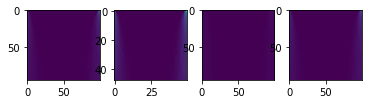

 15%|███████████████▋                                                                                          | 1479/10000 [01:48<08:43, 16.27it/s]

epoch: 1480/10000: train loss:0.0002778369962470606,valid_loss:0.00028854748234152794


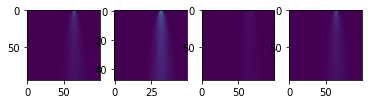

 15%|███████████████▊                                                                                          | 1489/10000 [01:49<08:41, 16.33it/s]

epoch: 1490/10000: train loss:0.00027845409931614995,valid_loss:0.00028854759875684977


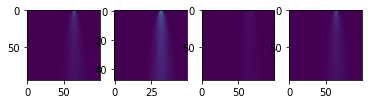

 15%|███████████████▉                                                                                          | 1499/10000 [01:50<08:40, 16.34it/s]

epoch: 1500/10000: train loss:0.0002751711435848847,valid_loss:0.0002885476278606802


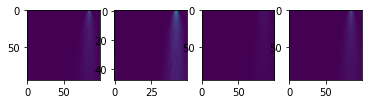

 15%|███████████████▉                                                                                          | 1509/10000 [01:50<08:50, 16.01it/s]

epoch: 1510/10000: train loss:0.00027706759283319116,valid_loss:0.0002885477733798325


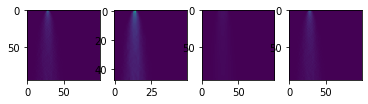

 15%|████████████████                                                                                          | 1519/10000 [01:51<09:33, 14.78it/s]

epoch: 1520/10000: train loss:0.0002760167990345508,valid_loss:0.00028854794800281525


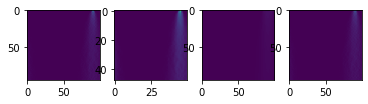

 15%|████████████████▏                                                                                         | 1529/10000 [01:52<08:50, 15.96it/s]

epoch: 1530/10000: train loss:0.00028188011492602527,valid_loss:0.0002885480644181371


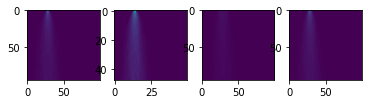

 15%|████████████████▎                                                                                         | 1539/10000 [01:53<08:42, 16.19it/s]

epoch: 1540/10000: train loss:0.0002766055113170296,valid_loss:0.0002885482390411198


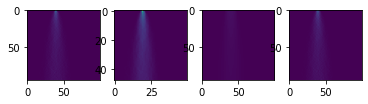

 16%|████████████████▍                                                                                         | 1550/10000 [01:54<10:21, 13.59it/s]


In [11]:
'粗粒化训练'
# loss_F1 = torch.nn.NLLLoss()
loss_kl = torch.nn.KLDivLoss(reduction='batchmean')
loss_F2 = torch.nn.MSELoss()
# seed = 2051
num_epochs = 10000
# # hidden_size = 1
# sgroup = 3
# tgroup = 9
torch.manual_seed(seed)
random.seed(seed)
model = TemporalSpatialConv(tgroup=tgroup, sgroup=sgroup)
model = model.cuda() if use_cuda else model
optimizer2 = optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
last_valid_loss = 10000
count = 0
train_losses2 = []
valid_losses2 = []
for epoch in tqdm(range(num_epochs)):#重复训练num_epoch次 
    loss_t2 = []
    loss_v2 = []
    model.train()
    for train_x,train_y in train_loader:
        if use_cuda:
            train_x = train_x.cuda()
            train_y = train_y.cuda()
        encoder = model.Encoder(train_x)
#         print(encoder.shape)
#         de
        b,t,l = encoder.shape
        macro_pred = dynamic(encoder.reshape(-1,l)).reshape(b,t,l)
        decoder = model.Decoder(macro_pred)
        loss = loss_F2(decoder.reshape(-1),train_y.reshape(-1))
        optimizer2.zero_grad()
        loss.backward()
        optimizer2.step()
        loss_t2.append(loss.item())
#         train_losses2.append(loss.item())
    train_losses2.append(np.mean(loss_t2))
    if epoch % 10 == 0:
        model.eval()
        for valid_x,valid_y in valid_loader:
            if use_cuda:
                valid_x = valid_x.cuda()
                valid_y = valid_y.cuda()
            encoder = model.Encoder(valid_x)
            b,t,l = encoder.shape
            macro_pred = dynamic(encoder.reshape(-1,l)).reshape(b,t,l)
            decoder = model.Decoder(macro_pred)
            loss = loss_F2(decoder.reshape(-1),valid_y.reshape(-1))
            loss_v2.append(loss.item())
        valid_losses2.append(np.mean(loss_v2))
        if np.mean(loss_v2) > last_valid_loss:
            count += 1
            if count > 10:
                break
        if np.mean(loss_v2) < last_valid_loss:
            count = 0
            print('save')

#             torch.save(model,f'./models/encoder/diffusion_encoder_sgroup={sgroup}_tgroup={tgroup}_sgroup_data={s_group_data}_{seed}.pth')
            last_valid_loss = np.mean(loss_v2)

        print(f'epoch: {epoch}/{num_epochs}: train loss:{np.mean(loss_t2)},valid_loss:{np.mean(loss_v2)}')
        plt.subplot(141)
        plt.imshow(valid_x[0],vmin=0,vmax=1)
        plt.subplot(142)
        plt.imshow(encoder[0].detach(),vmin=0,vmax=1)
        plt.subplot(143)
        plt.imshow(decoder[0].detach(),vmin=0,vmax=1)
        plt.subplot(144)
        plt.imshow(valid_y[0].detach(),vmin=0,vmax=1)
        plt.show()


In [12]:
# torch.save(model,f'./models/diffusion_encoder_sgroup={sgroup}_tgroup={tgroup}.pth.pth')

In [14]:
len(train_losses2),len(valid_losses2)

(1551, 156)

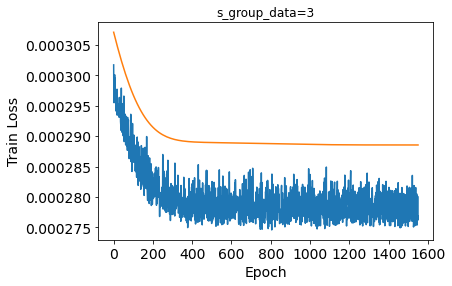

In [15]:
plt.plot(train_losses2)
plt.plot(np.arange(0,len(train_losses2),10),valid_losses2)
# plt.yscale('log')
plt.ylabel('Train Loss',fontsize=14)
plt.xlabel('Epoch',fontsize=14)
plt.title(f's_group_data={s_group_data}')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()